In [44]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns

In [45]:
df = pd.read_csv("flchain.csv")

cols= ['age', 'sex', 'sample.yr', 'kappa', 'lambda', 'flc.grp', 'creatinine', 'mgus', 'futime', 'death']
df = df[cols]
#fill NaN value with Mediam value
df['creatinine'] = df['creatinine'].fillna(df['creatinine'].median())
#Let F = 1, M = 0
d = {'F':0, 'M':1}
df['sex'] = df['sex'].apply(lambda x:d[x])

In [46]:
data_train=(df.loc[df['death']==1]).copy()
data_train.drop(['death'],1,inplace=True)
feature=[c for c in data_train.columns if c not in ['age']]
target=['age']

data_train.head()

,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime
0,97,0,1997,5.70,4.860,10,1.7,0,85
1,92,0,2000,0.87,0.683,1,0.9,0,1281
2,94,0,1997,4.36,3.850,10,1.4,0,69
3,92,0,1996,2.42,2.220,9,1.0,0,115
4,93,0,1996,1.32,1.690,6,1.1,0,1039


In [47]:
train=data_train[:]
val=data_train[:]

In [48]:
from keras.layers import Activation, Dense, Dropout
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential

In [49]:
NN_model = Sequential()
NN_model.add(Dense(32, kernel_initializer='normal'))
NN_model.add(Dense(1, kernel_initializer='normal'))    
NN_model.add(Activation('linear'))
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

history=NN_model.fit(train[feature].values, train[target].values, epochs=19, batch_size=10)


preds = NN_model.predict(val[feature].values) 
score = mean_absolute_error(val[target].values, preds)
print(score)

Epoch 1/19
2169/2169 [==============================] - 0s 200us/step - loss: 9.4404 - mean_absolute_error: 9.4404
Epoch 2/19
2169/2169 [==============================] - 0s 108us/step - loss: 8.7698 - mean_absolute_error: 8.7698
Epoch 3/19
2169/2169 [==============================] - 0s 108us/step - loss: 8.7193 - mean_absolute_error: 8.7193 0s - loss: 8.6838 - mean_absolute_error: 8.68
Epoch 4/19
2169/2169 [==============================] - 0s 100us/step - loss: 8.4055 - mean_absolute_error: 8.4055
Epoch 5/19
2169/2169 [==============================] - 0s 104us/step - loss: 8.6228 - mean_absolute_error: 8.6228
Epoch 6/19
2169/2169 [==============================] - 0s 106us/step - loss: 8.5790 - mean_absolute_error: 8.5790
Epoch 7/19
2169/2169 [==============================] - 0s 104us/step - loss: 8.5849 - mean_absolute_error: 8.5849
Epoch 8/19
2169/2169 [==============================] - 0s 103us/step - loss: 8.6001 - mean_absolute_error: 8.6001
Epoch 9/19
2169/2169 [============

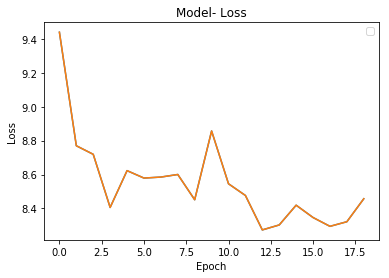

In [51]:
fig2, ax_loss = plt.subplots()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model- Loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.plot(history.history['loss'])
plt.plot(history.history['mean_absolute_error'])
plt.show()

In [52]:
# me=np.array([24, 1, 1997, 5.79, 4.5466, 9, 1.5, 0, 44])
# data_test=(df.loc[df['death']==0]).copy()
# data_test.drop(['death'],1,inplace=True)
# data_test.loc[-1] = me
# estimation = NN_model.predict(data_test[feature].values)

In [53]:
# estimation[-1]
# print("age: {}".format(estimation[-1]))

In [54]:
import lightgbm as lgb
feature=[c for c in data_train.columns if c not in ['death']]
target=df['death']

In [55]:
from sklearn.model_selection import StratifiedKFold
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
predict = np.zeros(len(df))
feature_importance_df = pd.DataFrame()

In [56]:
param={
       'bagging_fraction': 0.33,
       'boost_from_average':'false',
       'boost': 'gbdt',
       'max_depth': -1,
       'metric':'auc',
       'objective': 'binary',
       'verbosity': 1
    }

In [57]:
from sklearn.metrics import roc_auc_score
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(df.iloc[trn_idx][feature], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df.iloc[val_idx][feature], label=target.iloc[val_idx])

    num_round = 500
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 50)
    predict[val_idx] = clf.predict(df.iloc[val_idx][feature], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = feature
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    

print("CV score: {:<8.5f}".format(roc_auc_score(target, predict)))

Fold 0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	training's auc: 0.987486	valid_1's auc: 0.974658
Fold 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	training's auc: 0.991244	valid_1's auc: 0.966846
Fold 2
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	training's auc: 0.981549	valid_1's auc: 0.965349
Fold 3
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	training's auc: 0.984133	valid_1's auc: 0.976503
Fold 4
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	training's auc: 0.984737	valid_1's auc: 0.970022
Fold 5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	training's auc: 0.987724	valid_1's auc: 0.974824
Fold 6
Training until validation scores don't improve for 

In [58]:
feature_importance_df.head()

,Feature,importance,fold
0,age,247,1
1,sex,26,1
2,sample.yr,249,1
3,kappa,137,1
4,lambda,165,1


In [59]:
try1=feature_importance_df.groupby(['Feature'],as_index=False).mean()
try1.drop(['fold'],1,inplace=True)

Text(0.5, 1.0, 'LightGBM Features (average_for_all_fold)')

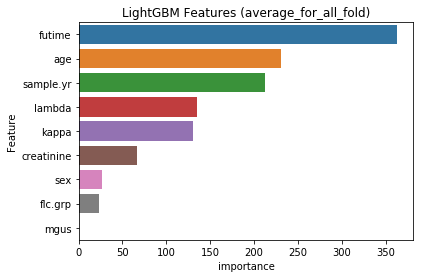

In [60]:
sns.barplot(x="importance", y="Feature", data=try1.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (average_for_all_fold)')